# Load data

## Data Description

| column            | dtype          | description                                                      | Sample                           |
|:------------------|:---------------|:-----------------------------------------------------------------|:---------------------------------|
| date              | datetime64[ns] | Date of the report                                               | 2022-01-08 0:00:00               |
| version_number    | object         | CrowdSec version number                                          | v1.2.2                           |
| scenario          | object         | Name of the crowdsec scenario                                    | crowdsecurity/ssh-slow-bf        |
| watcher_id        | Int64          | id of the watcher installation                                   | 111566                           |
| ip                | object         | Reported IP                                                      | 31.184.198.71                    |
| id                | Int64          | Reported IP ID                                                   | 153806                           |
| rdns              | object         | RDNS for the Reported IP                                         | nan                              |
| country           | object         | Country for the Reported IP                                      | RU                               |
| as_num            | Int64          | AS Nunber for the Reported IP                                    | 34665                            |
| as_name           | object         | Autonomous System Organization Name                              | Petersburg Internet Network ltd. |
| Config            | object         | Type of the machine in the article                               | MachineA#NoBouncer               |
| scenario_category | object         | High-level category for each scenario                            | Bruteforce                       |
| malevolence_score | int64          | Malevolence score for the reported IP graded by the CrowdSec API | 5                                |

In [7]:
import os
from pathlib import Path

import pandas as pd
import plotly.express as px

pd.options.plotting.backend = "plotly"
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

In [8]:
EXPORT_IMAGES_DIR = Path("~/Documents/csdrive/twin_machines_article").expanduser()
EXPORT_IMAGES_DIR.mkdir(exist_ok=True, parents=True)
CONFIG_COL = "Config"
FREQ = "W"

df = pd.read_parquet(
    "data/twin-machines-signals.parq"
)
# Or alternatively load in csv
# df2 = pd.read_csv('data/twin-machines-signals.csv')

# EDA
## Number of alerts and IPs

In [9]:
g = df.groupby([CONFIG_COL])
g.agg(ips_reported=("ip", "nunique"), n_alerts=("ip", "size"))

,ips_reported,n_alerts
Config,,
MachineA#NoBouncer,149,1973
MachineB#Bouncer,91,168


## Number of Average Alerts per Day

In [23]:
g = df.groupby([pd.Grouper(key='date', freq='D'), CONFIG_COL])
dd = g.size().rename('alerts_per_day').groupby(CONFIG_COL).mean().rename('average_alerts_per_day').to_frame()
dd

,average_alerts_per_day
Config,
MachineA#NoBouncer,24.974684
MachineB#Bouncer,3.294118


## Average NUmber of Alerts per IPs 

In [14]:
average_alerts_by_ip_df = (
    df.groupby(["ip", CONFIG_COL]).size().groupby(CONFIG_COL).mean()
)
average_alerts_by_ip_df.to_frame("average_alerts_per_ip")

,average_alerts_per_ip
Config,
MachineA#NoBouncer,13.241611
MachineB#Bouncer,1.846154


# Viz

## Plotly config (optional)

In [15]:
import plotly.graph_objects as go
import plotly.io as pio
import os

CONSOLE_COLORWAY = ["#5D54B0",
"#FFC343",
"#C3BEF3",
"#4C91C2",
"#B90C85",
"#FFD1E4",
"#E21717",
"#F17C4E",
"#9E5C4F",
"#3EBB3E",]

CS_COLORWAY = [
    "#FFAD01",
    "#5146AE",
    "#1F92FC",
    "#636466",
    "#6DD79A",
    "#FF3C31",
    "#5952FF",
    "#FCC028",
    "#A7D4FF",
    "#9d9fa2",
    "#BAEED0",
    "#FFA6A0",
    "#B5AEFF",
    "#FFE49A",
]
draft_template = go.layout.Template()
template_dict = dict(
        layout=dict(
            legend=dict(
                yanchor="top",
                y=0.99,
                xanchor="right",
            ),
            title_x=0.5,
            margin=dict(
                t=60,
                b=60,
                l=60,
                r=60,
            ),
            xaxis=dict(automargin=True, showgrid=False, title=None),
            yaxis=dict(automargin=True, title=None),
            colorway=CONSOLE_COLORWAY,
        ),
    )
pio.templates["crowdsec"] =  draft_template.update(template_dict, overwrite=True)
pio.templates.default = "crowdsec"
# pio.renderers.default = 'png' # to display in GitHub 
# https://github.com/plotly/plotly.py/issues/931
# Change to plotly_mimetype+notebook when running interactively or check pio.renderers.keys()

## Viz routines

In [16]:
import unicodedata
import re

def slugify(value, allow_unicode=False):
    """
    Taken from https://github.com/django/django/blob/master/django/utils/text.py
    Convert to ASCII if 'allow_unicode' is False. Convert spaces or repeated
    dashes to single dashes. Remove characters that aren't alphanumerics,
    underscores, or hyphens. Convert to lowercase. Also strip leading and
    trailing whitespace, dashes, and underscores.
    """
    value = str(value)
    if allow_unicode:
        value = unicodedata.normalize('NFKC', value)
    else:
        value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    value = re.sub(r'[^\w\s-]', '', value.lower())
    return re.sub(r'[-\s]+', '-', value).strip('-_')

In [17]:
def save_fig(fig, title, root_dir=EXPORT_IMAGES_DIR, ext='.png', suffix=None):
    filename = "-".join(filter(None, (slugify(title), suffix))) + ext
    return fig.write_image(root_dir / filename)

## Number of Unique IPs reported

In [19]:
unique_ips = (
    df.groupby([CONFIG_COL, pd.Grouper(freq=FREQ, key="date")])["ip"]
    .nunique()
    .rename("ips_reported")
    .reset_index(level=CONFIG_COL)
)

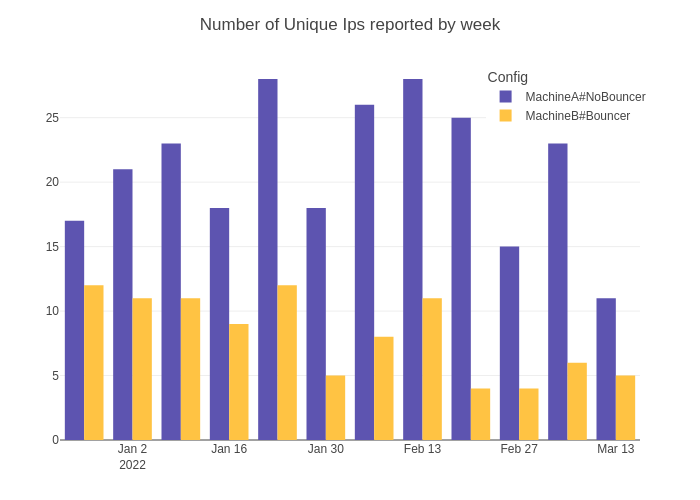

In [20]:
title = f"Number of Unique Ips reported by week"
fig = (
    unique_ips.plot.bar(
        title=title,
        color=CONFIG_COL,
        barmode="group",
    )
    .update_xaxes(title=None)
    .update_yaxes(title=None)
)
save_fig(fig, title)
fig

## Alerts

In [21]:
ts = (
    df.groupby([CONFIG_COL, pd.Grouper(freq=FREQ, key="date")])
    .size()
    .rename("n_alerts")
    .reset_index(level=CONFIG_COL)
)

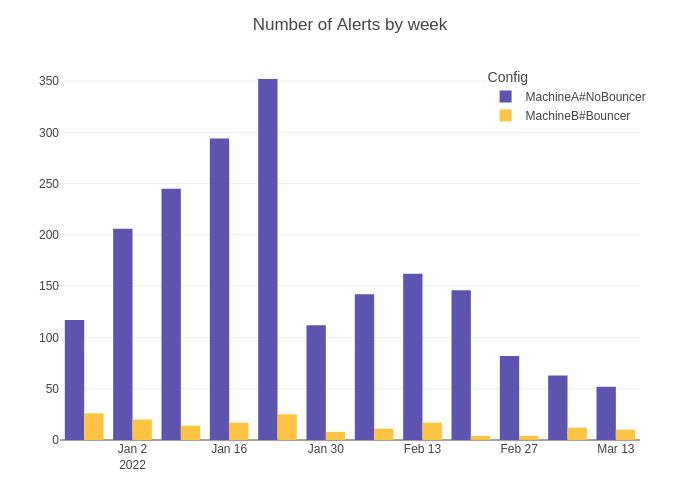

In [22]:
title = "Number of Alerts by week"
filename = slugify(title) + ".png"
fig = (
    ts.plot.bar(
        color=CONFIG_COL,
        title=title,
        barmode="group",
    )
    .update_xaxes(title=None)
    .update_yaxes(title=None)
)
save_fig(fig, title)
fig

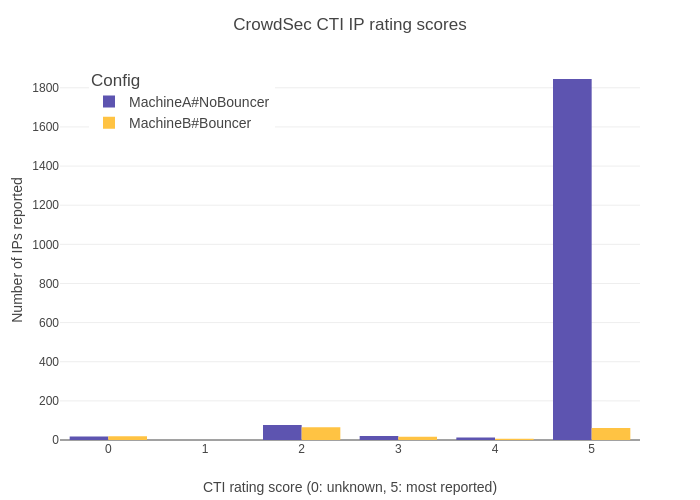

In [23]:
title = "CrowdSec CTI IP rating scores"
fig = (
    px.histogram(
        df,
        "malevolence_score",
        color=CONFIG_COL,
        orientation='v',
        barmode="group",
        title=title,
    )
    .update_layout(legend=dict(yanchor="top",font=dict(size=14), y=0.99, xanchor="left", x=0.05))
    .update_xaxes(title="CTI rating score (0: unknown, 5: most reported)")
    .update_yaxes(title="Number of IPs reported")
)
save_fig(fig, title)
fig

## Scenario distribution and IP Score

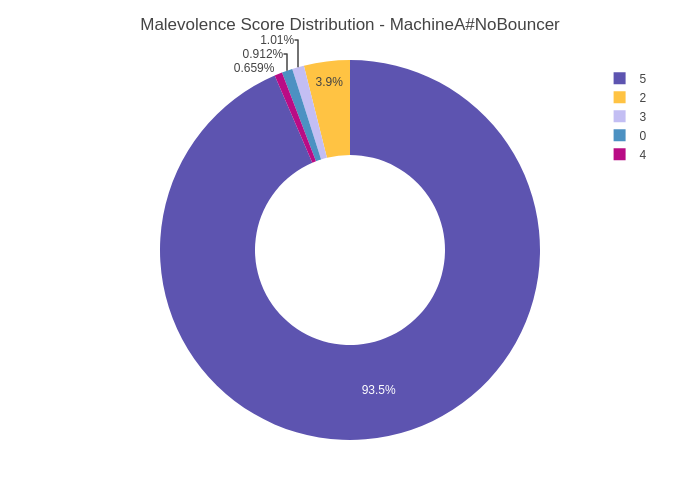

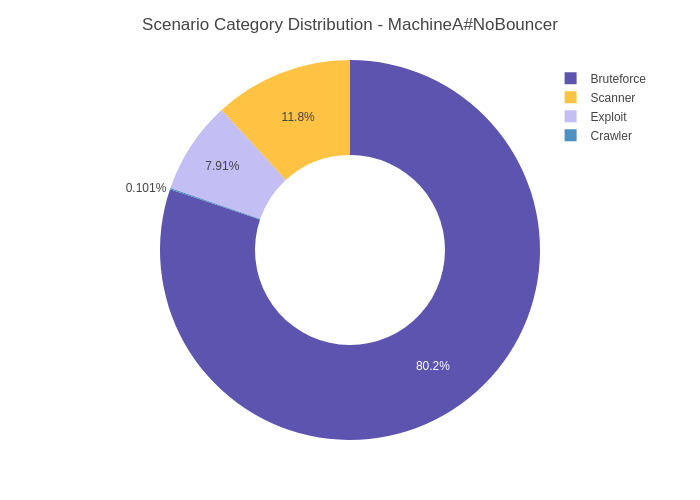

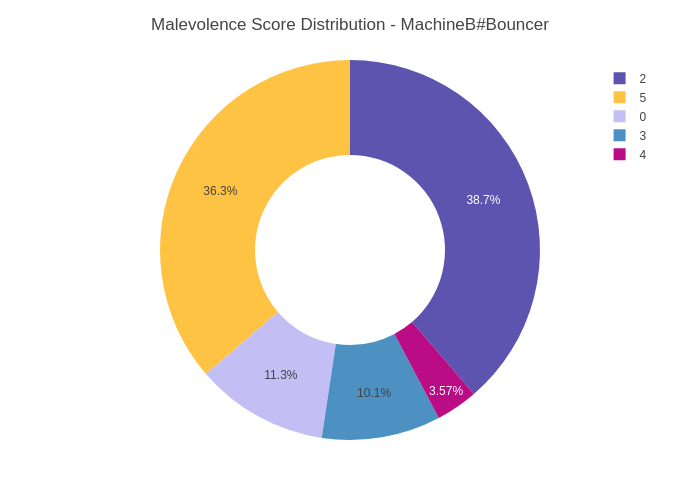

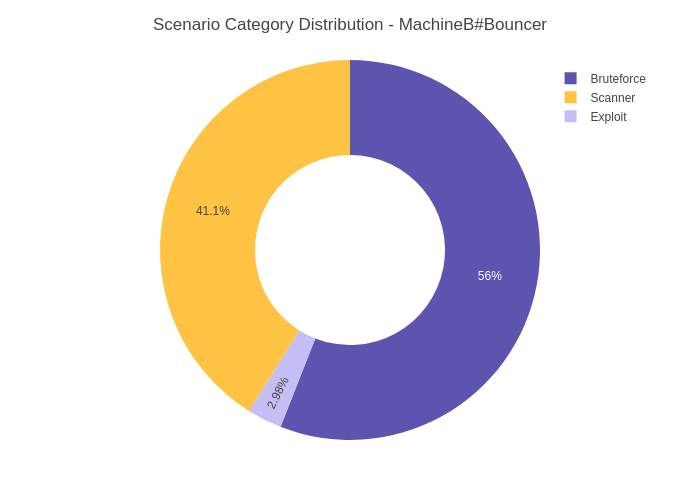

In [24]:
for group, dd in df.groupby(CONFIG_COL):
    title = f"Malevolence Score Distribution - {group}"
    fig = px.pie(dd, "malevolence_score", title=title, labels="score", hole=0.5)
    save_fig(fig, title)
    fig.show()
    title = f"Scenario Category Distribution - {group}"
    fig = px.pie(dd, "scenario_category", title=title, labels="scenario", hole=0.5)
    save_fig(fig, title)
    fig.show()
    
# GRoup bar plot
title = f"Scenario Category Distribution"
fig = px.histogram(df, "scenario_category", color=CONFIG_COL, title=title, barmode='group').update_xaxes(
    title=None
).update_yaxes(title="Number of IPs Reported", automargin=True).update_layout(
    showlegend=True
)
save_fig(fig, title, suffix="bar")